# Obligatorio Machine Learning para IA

### Ramiro Sanes y Joaquin Guerra

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import joblib
import imageio.v2 as imageio

from tqdm import tqdm
from random import sample
import seaborn as sns

from skimage import data, color
from skimage.transform import resize

from skimage import exposure

from skimage import exposure

from sklearn.feature_extraction.image import PatchExtractor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

from utils import extract_patches

plt.style.use('ggplot')

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

In [3]:
images = []

# Creamos el directorio de Background si no existe
if not os.path.exists('Background'):
    os.makedirs('Background')
    #Descargamos el archivo zip de Background
    with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
        zip_ref.extractall('Background')

# Cargamos imagenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Cargamos imagenes de Background
# iteramos en todas las files de background
for file in os.listdir('Background'):
    if file.endswith('.jpg'):
        filename = os.path.join('Background', file)
        img = plt.imread(filename)
        if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
            img = color.rgb2gray(img)
        images.append(resize(img, (100,100)))

# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 150, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape


Procesando imágenes: 100%|██████████| 40/40 [00:07<00:00,  5.45it/s]


(30000, 64, 64)

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [4]:
faces = []

#Cargamos caras
if not os.path.exists('Faces'):
    os.makedirs('Faces')
    with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
        zip_ref.extractall()


all_files = os.listdir('Faces')
pgm_files = [filename for filename in all_files if filename.endswith('.pgm')]

for filename in tqdm(pgm_files):
    path = os.path.join('Faces', filename)
    image = imageio.imread(path)
    faces.append(image)

faces_array = np.stack(faces)
faces_array = faces_array / 255.0

100%|██████████| 12833/12833 [00:08<00:00, 1532.80it/s]


In [5]:
  # Etiquetas para las imágenes de rostros
X_faces = faces_array
y_faces = [1] * len(X_faces)

 # Etiquetas para las imágenes de fondo
X_fondos = negative_patches
y_fondos = [0] * len(X_fondos)

# Etiquetas combinadas
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])

Agregar lo de visualizacion en otro arrei

In [6]:
#Obtenemos hog features para las imagenes en X
hog_features = []
# Si existe el archivo hog_features.npy, lo cargamos
if os.path.exists('hog_features.npz'):
    hog_features = np.load('hog_features.npz')
else:
    for img in tqdm(X, desc='Extrayendo HOG features'):
        fd = hog(img, visualize=False)
        hog_features.append(fd)
    #Guardamos las features en un archivo
    hog_features = np.array(hog_features)
    np.savez_compressed('hog_features.npz', array=hog_features)



Extrayendo HOG features: 100%|██████████| 42833/42833 [01:08<00:00, 629.57it/s]


In [7]:
#Aplanamos las features
hog_features = np.vstack(hog_features)
X_flatten = np.array([im.flatten() for im in tqdm(hog_features, desc='Construyendo hog_features')])

Construyendo hog_features: 100%|██████████| 42833/42833 [00:00<00:00, 156679.73it/s]


In [9]:
pca_values = [450] # Your desired components
pca_dict = {}

for i in pca_values:
    #Hacemos PCA para cada valor de componentes (PCA no incremental)
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_flatten)
    pca_dict[i] = pca



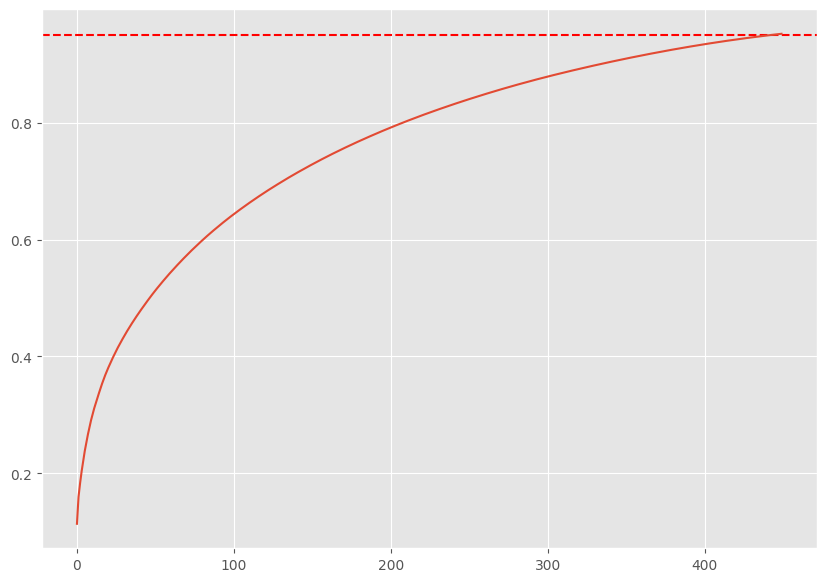

In [10]:
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.plot(np.cumsum(pca_dict[450].explained_variance_ratio_), label=f'{450} componentes')
plt.show()

Tomamos 450 como la cantidad de componentes principales ya que pasa el umbral definido de 95% de la varianza explicada

In [11]:
pca_final = pca_dict[450]

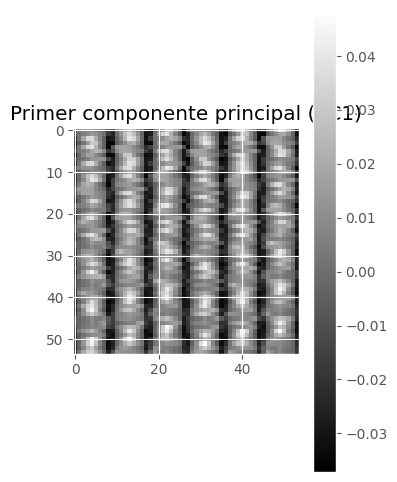

In [12]:
pc1 = pca_final.components_[0]  # Shape: (4096,)

# Visualizar el hog como imagen
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(pc1.reshape(54, 54), cmap='gray')
plt.title("Primer componente principal (PC1)")
plt.colorbar()
plt.show()

### Visualizamos las primeras componentes

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_flatten, y, test_size=0.1, random_state=42)

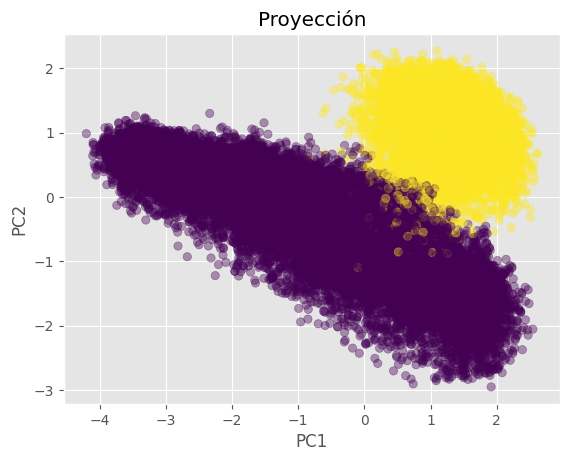

In [14]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

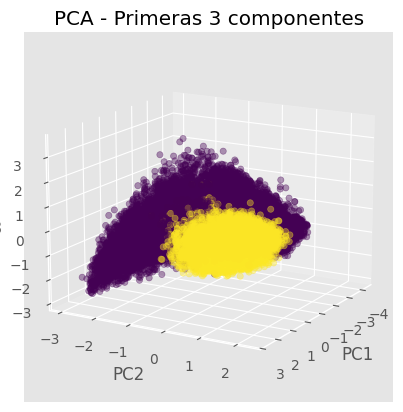

In [15]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

In [16]:
df = pd.DataFrame(X_pca_train, columns=[f'PC{i+1}' for i in range(X_pca_train.shape[1])])
df['y'] = y_train
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC442,PC443,PC444,PC445,PC446,PC447,PC448,PC449,PC450,y
0,-2.874966,-0.033999,0.348459,-0.880310,-0.517436,-0.063585,-0.828964,-0.176203,-0.069173,0.076483,...,0.150735,-0.009855,-0.022459,0.021620,-0.105221,0.054160,0.024926,-0.048217,-0.002125,0
1,0.089440,-0.383554,-0.621632,0.035293,0.130706,-0.487863,1.029759,-0.637861,-0.505682,0.688755,...,-0.076907,0.071304,-0.044310,-0.029510,0.106819,-0.053486,0.087959,-0.110505,0.039246,0
2,-0.898549,-0.104896,-1.107066,1.079949,-0.124762,-0.371729,-0.699101,-0.869111,0.946737,1.868367,...,-0.021152,0.032564,0.191980,0.134544,-0.029567,0.057473,0.013401,-0.084281,0.028520,0
3,1.174185,0.971159,0.193351,-0.508386,1.191609,-0.315018,0.292449,-0.645349,-0.293311,0.234552,...,0.003296,-0.064855,-0.076975,-0.046953,-0.056575,0.073902,-0.005693,-0.035049,-0.094934,1
4,-2.157070,-0.412075,-0.042664,-0.443882,-0.102749,-0.805197,0.061308,1.570194,0.399211,-0.705752,...,0.037456,0.073136,0.057687,0.001636,-0.034569,0.006989,0.021392,-0.084396,0.093388,0


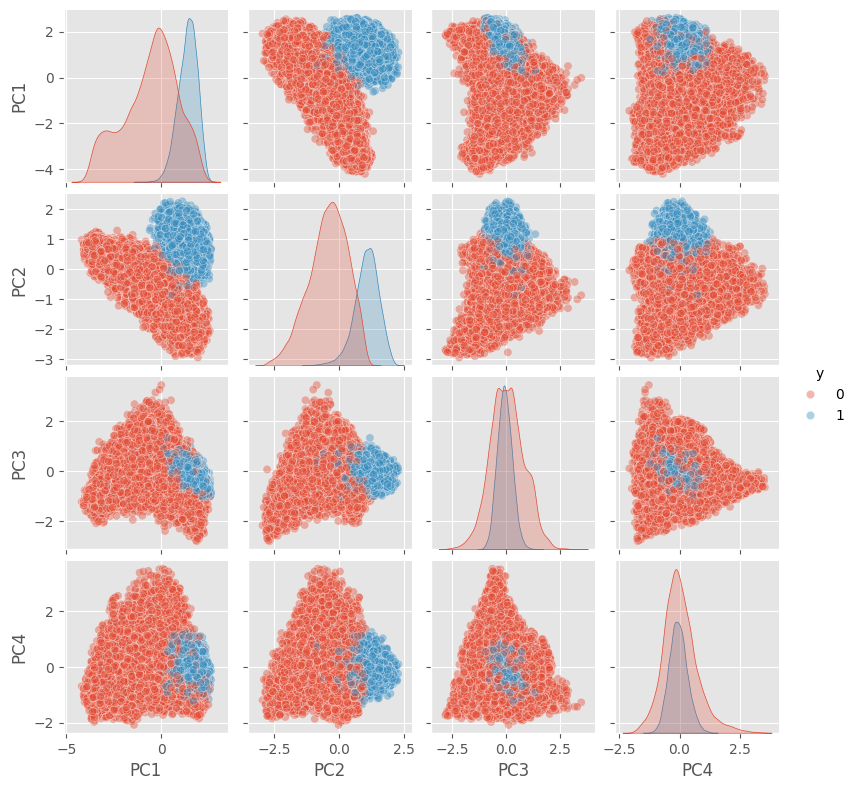

In [17]:
sns.pairplot(df, vars=['PC1','PC2','PC3','PC4'], diag_kind='kde', height=2, plot_kws={'alpha':0.4}, hue='y',)
plt.show()

### Modelo sencillo de clasificación

In [18]:
tree_dict = {}
scores = {}
for i in [2,5,10]:
    tree_dict[i] = DecisionTreeClassifier(max_depth=i,random_state=42)
    tree_dict[i].fit(X_pca_train, y_train)
    scores[i] = cross_val_score(tree_dict[i], X_pca_train, y_train, cv=5, scoring='accuracy')
    print(f"Score con {i} profundidad: {np.mean(scores[i])}")


Score con 2 profundidad: 0.9519053462028901
Score con 5 profundidad: 0.9917766539993428
Score con 10 profundidad: 0.990868759021199


In [19]:
X_pca_val = pca_final.transform(X_val)

In [20]:
test_accuracies = {}
for i in [2,5,10]:
    test_accuracies[i] = tree_dict[i].score(X_pca_val, y_val)
    print("Accuracy en test con profundidad", i, ":", test_accuracies[i])

Accuracy en test con profundidad 2 : 0.9474789915966386
Accuracy en test con profundidad 5 : 0.9904295051353875
Accuracy en test con profundidad 10 : 0.9911297852474323


### Probamos en Test

In [21]:
import zipfile

with zipfile.ZipFile('Test.zip', 'r') as zip_ref:
    zip_ref.extractall('Test')

In [22]:
suffix = '.pgm'

all_files = os.listdir('Test/Test')
pgm_files_test = [filename for filename in all_files if filename.endswith(suffix)]

In [23]:
test_images = []
for filename in tqdm(pgm_files_test):
    path = os.path.join('Test/Test', filename)
    image = imageio.imread(path)  # mucho más rápido que plt.imread
    test_images.append(image)

100%|██████████| 8000/8000 [00:05<00:00, 1404.44it/s]


In [24]:
test_array = np.stack(test_images)

In [25]:
test_array = test_array / 255.0

In [26]:
# Aplicamos a test_array la funcion hog con los mismos parametros que anteriormente
hog_features_test = []
for img in tqdm(test_array, desc='Extrayendo HOG features'):
    fd = hog(img, visualize=False)
    hog_features_test.append(fd)

#transformamos en array y stackeamos
test_array = np.array(hog_features_test)
test_array = np.vstack(hog_features_test)

#Aplanamos
X_test_flatten = np.array([im.flatten() for im in tqdm(test_array, desc='Construyendo X')])

Construyendo X: 100%|██████████| 8000/8000 [00:00<00:00, 24755.96it/s]


In [27]:
print("Media - Test:", np.mean(X_test_flatten))

Media - Test: 0.06864296662850264


In [28]:
X_test_pca = pca_final.transform(X_test_flatten)

Prueba con XGB

In [29]:
# Probamos entrenando un modelo XGB y probamos en X_test_pca
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_pca_train, y_train)
y_pred = xgb_model.predict(X_pca_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy en test con XGB:", accuracy)

Accuracy en test con XGB: 0.9971988795518207


In [30]:
y_test = xgb_model.predict(X_test_pca)

In [31]:
test_df = pd.DataFrame(X_test_flatten)

In [32]:
test_df['prediccion'] = y_test

In [33]:
test_df.value_counts('prediccion')

,count
prediccion,
0,7595
1,405


In [34]:
# Guardamos xgb_model
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [35]:
# Guardamos el pca
joblib.dump(pca_final, 'pca_final_2025-06-08.pkl')

['pca_final_2025-06-08.pkl']